 - Classifying CIFAR-10 using the simple version of DenseNet. The model contains ~1 million parameters.
 - Code written with TensorFlow2.0-beta0
 - DenseNet Paper: https://arxiv.org/pdf/1608.06993.pdf
 - Original Implementation: https://github.com/liuzhuang13/DenseNet

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
def conv_block(x, input_shape):
  x = tf.keras.layers.BatchNormalization(input_shape=input_shape)(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=growth_rate, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(x)
  return x

def dense_block(x, num_conv_layers):
  concat_feat = x
  for ctr in range(num_conv_layers):
    x = conv_block(concat_feat, concat_feat.shape[1:])
    concat_feat = tf.keras.layers.concatenate([concat_feat, x])
  return concat_feat

def transition_block(x):
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.Conv2D(filters=x.shape[-1], kernel_size=1, strides=1, kernel_initializer='he_normal')(x)
  x = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)(x)
  return x

In [3]:
def create_model():
  inputs = tf.keras.layers.Input(shape=(32, 32, 3))
  
  # Initial Conv1
  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  
  # Dense Block 1
  x = dense_block(x, 12)
  x = transition_block(x)
  
  # Dense Block 2
  x = dense_block(x, 12)
  x = transition_block(x)
  
  # Dense Block 3
  x = dense_block(x, 12)
  
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation('relu')(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  
  x = tf.keras.layers.Dense(num_classes)(x)
  outputs = tf.keras.layers.Activation('softmax')(x)
  
  model = tf.keras.Model(inputs, outputs)
  
  return model

In [4]:
num_classes = 10
BATCH_SIZE = 256
BUFFER = 10000
growth_rate = 12
lr_init = 0.1
EPOCHS = 300

In [5]:
def lrate(epoch):
  if (epoch > (EPOCHS / 2)):
    return 0.01
  elif (epoch > (0.75 * EPOCHS)):
    return 0.001
  return 0.1

In [6]:
chkpt = tf.keras.callbacks.ModelCheckpoint('.', monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=5)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=150, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
lrate_sched = tf.keras.callbacks.LearningRateScheduler(lrate, verbose=1)

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train_mean = np.mean(x_train, axis=0)
x_train -= x_train_mean
x_test -= x_train_mean

# Convert to One-Hot Encoding format.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [8]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

datagen.fit(x_train)

In [9]:
# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
sgd = tf.keras.optimizers.SGD(lr=lr_init, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),epochs=EPOCHS,
                              validation_data=(x_test, y_test),steps_per_epoch=len(x_train)/BATCH_SIZE,
                              callbacks=[lrate_sched, early_stop])


Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
Epoch 1/300


W0618 05:30:50.892235 139767861499712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


196/195 [==============================] - 126s 645ms/step - loss: 1.3750 - accuracy: 0.4974 - val_loss: 3.7497 - val_accuracy: 0.3277

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
Epoch 2/300
196/195 [==============================] - 100s 511ms/step - loss: 0.9329 - accuracy: 0.6686 - val_loss: 1.3734 - val_accuracy: 0.5858

Epoch 00003: LearningRateScheduler reducing learning rate to 0.1.
Epoch 3/300
196/195 [==============================] - 100s 511ms/step - loss: 0.7544 - accuracy: 0.7354 - val_loss: 0.9816 - val_accuracy: 0.6719

Epoch 00004: LearningRateScheduler reducing learning rate to 0.1.
Epoch 4/300
196/195 [==============================] - 100s 508ms/step - loss: 0.6489 - accuracy: 0.7744 - val_loss: 0.9042 - val_accuracy: 0.6988

Epoch 00005: LearningRateScheduler reducing learning rate to 0.1.
Epoch 5/300
196/195 [==============================] - 100s 511ms/step - loss: 0.5753 - accuracy: 0.7986 - val_loss: 0.8113 - val_accuracy: 0.7329

Epoch 00

196/195 [==============================] - 100s 509ms/step - loss: 0.0608 - accuracy: 0.9785 - val_loss: 0.5067 - val_accuracy: 0.8853

Epoch 00078: LearningRateScheduler reducing learning rate to 0.1.
Epoch 78/300
196/195 [==============================] - 99s 508ms/step - loss: 0.0617 - accuracy: 0.9778 - val_loss: 0.6870 - val_accuracy: 0.8588

Epoch 00079: LearningRateScheduler reducing learning rate to 0.1.
Epoch 79/300
196/195 [==============================] - 100s 508ms/step - loss: 0.0610 - accuracy: 0.9784 - val_loss: 0.5411 - val_accuracy: 0.8812

Epoch 00080: LearningRateScheduler reducing learning rate to 0.1.
Epoch 80/300
196/195 [==============================] - 100s 511ms/step - loss: 0.0591 - accuracy: 0.9787 - val_loss: 0.4172 - val_accuracy: 0.8968

Epoch 00081: LearningRateScheduler reducing learning rate to 0.1.
Epoch 81/300
196/195 [==============================] - 99s 506ms/step - loss: 0.0557 - accuracy: 0.9806 - val_loss: 0.4645 - val_accuracy: 0.8887

Epoch 

196/195 [==============================] - 99s 507ms/step - loss: 0.0113 - accuracy: 0.9964 - val_loss: 0.4081 - val_accuracy: 0.9177

Epoch 00154: LearningRateScheduler reducing learning rate to 0.01.
Epoch 154/300
196/195 [==============================] - 100s 508ms/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0.4011 - val_accuracy: 0.9181

Epoch 00155: LearningRateScheduler reducing learning rate to 0.01.
Epoch 155/300
196/195 [==============================] - 99s 506ms/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.4057 - val_accuracy: 0.9169

Epoch 00156: LearningRateScheduler reducing learning rate to 0.01.
Epoch 156/300
196/195 [==============================] - 100s 509ms/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0.3952 - val_accuracy: 0.9195

Epoch 00157: LearningRateScheduler reducing learning rate to 0.01.
Epoch 157/300
196/195 [==============================] - 100s 509ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.3946 - val_accuracy: 0.9201

196/195 [==============================] - 100s 508ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.4077 - val_accuracy: 0.9200

Epoch 00192: LearningRateScheduler reducing learning rate to 0.01.
Epoch 192/300
196/195 [==============================] - 100s 508ms/step - loss: 0.0044 - accuracy: 0.9988 - val_loss: 0.4161 - val_accuracy: 0.9187

Epoch 00193: LearningRateScheduler reducing learning rate to 0.01.
Epoch 193/300
196/195 [==============================] - 100s 511ms/step - loss: 0.0045 - accuracy: 0.9986 - val_loss: 0.4086 - val_accuracy: 0.9202

Epoch 00194: LearningRateScheduler reducing learning rate to 0.01.
Epoch 194/300
196/195 [==============================] - 99s 508ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.4058 - val_accuracy: 0.9201

Epoch 00195: LearningRateScheduler reducing learning rate to 0.01.
Epoch 195/300
196/195 [==============================] - 99s 506ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.4049 - val_accuracy: 0.9213

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

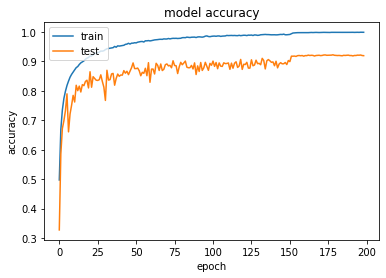

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

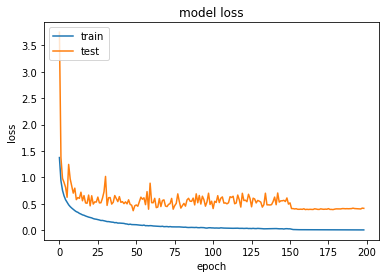

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()